In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [4]:
from collections import Counter

from itertools import chain

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

#Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost
from xgboost import XGBRegressor, plot_importance 

### EDA

In [5]:
# Download data
df_house_price_sample=pd.read_csv('house_price_sample_submission.csv')
df_house_price_test=pd.read_csv('house_price_test.csv').drop(columns='Id')
df_house_price_train=pd.read_csv('house_price_train.csv').drop(columns='Id')
df_house_price_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Explore numbers dataset
df_house_price_train_numbers=df_house_price_train.select_dtypes(include=['number'])
df_house_price_train_numbers.shape

(1460, 37)

In [7]:
# Add subplots
#for i in range(len(df_house_price_train_numbers.columns)):
#    sns.regplot(y=df_house_price_train_numbers.columns[i],x='SalePrice',data=df_house_price_train_numbers)
#    plt.show()
#    plt.hist(df_house_price_train_numbers[df_house_price_train_numbers.columns[i]],orientation='horizontal')
#    plt.show()

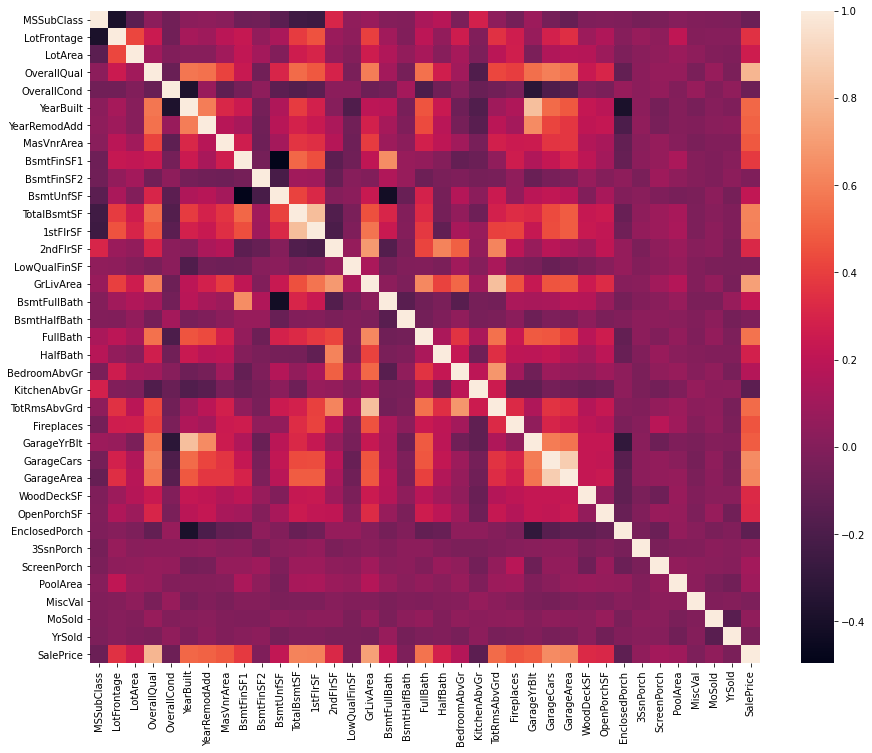

In [8]:
corr = df_house_price_train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr)
plt.show()

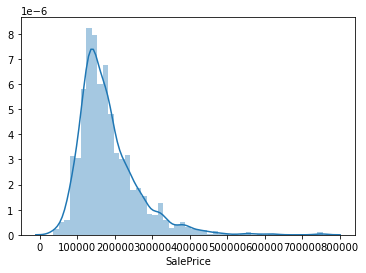

In [9]:
sns.distplot(df_house_price_train['SalePrice'])
plt.show()

### Data Cleaning

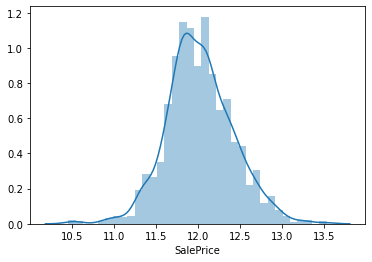

In [10]:
df_house_price_train["SalePrice"] = np.log1p(df_house_price_train["SalePrice"])
sns.distplot(df_house_price_train['SalePrice'])

In [11]:
df_house_price_train.shape

(1460, 80)

In [12]:
# Remove outliers
df_house_price_train.drop(df_house_price_train[(df_house_price_train['OverallQual']<5) & (df_house_price_train['SalePrice']>200000)].index, inplace=True)
df_house_price_train.drop(df_house_price_train[(df_house_price_train['GrLivArea']>4500) & (df_house_price_train['SalePrice']<300000)].index, inplace=True)

In [13]:
df_house_price_train.shape

(1458, 80)

In [14]:
# Split features and labels
df_house_price_sale_price = df_house_price_train['SalePrice']
df_house_price_train_features = df_house_price_train.drop(columns='SalePrice')
df_house_price_test_features = df_house_price_test

### Feature Engineering

In [15]:
df_house_price_features = pd.concat([df_house_price_train_features,df_house_price_test_features],axis=0).reset_index(drop=True)
df_house_price_features.reset_index(drop=True, inplace=True)

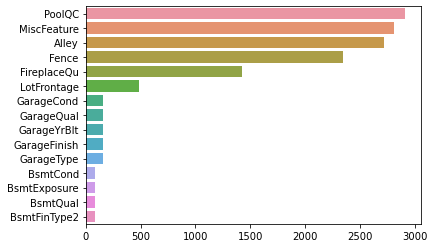

In [16]:
# Bar chart of missing values
df_house_price_train_objects_missing_data=df_house_price_features.isnull().sum().sort_values(ascending=False).head(15)
sns.barplot(y=df_house_price_train_objects_missing_data.index,x=df_house_price_train_objects_missing_data)
plt.show()

In [17]:
# Correctly set Mo and Yr as strings for label encoding
df_house_price_features['MoSold']=df_house_price_features['MoSold'].astype('str')
df_house_price_features['YrSold']=df_house_price_features['YrSold'].astype('str')
df_house_price_features['MSSubClass']=df_house_price_features['MSSubClass'].astype('str')
# the data description states that NA refers to typical ('Typ') values
df_house_price_features['Functional'] = df_house_price_features['Functional'].fillna('Typ')
df_house_price_features['Electrical'] = df_house_price_features['Electrical'].fillna("SBrkr")
df_house_price_features['KitchenQual'] = df_house_price_features['KitchenQual'].fillna("TA")
df_house_price_features['Exterior1st'] = df_house_price_features['Exterior1st'].fillna(df_house_price_features['Exterior1st'].mode()[0])
df_house_price_features['Exterior2nd'] = df_house_price_features['Exterior2nd'].fillna(df_house_price_features['Exterior2nd'].mode()[0])
df_house_price_features['SaleType'] = df_house_price_features['SaleType'].fillna(df_house_price_features['SaleType'].mode()[0])
df_house_price_features['MSZoning'] = df_house_price_features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
# the data description stats that NA refers to "No Pool"
df_house_price_features["PoolQC"] = df_house_price_features["PoolQC"].fillna("None")
df_house_price_features[['GarageYrBlt','GarageArea','GarageCars']]=df_house_price_features[['GarageYrBlt','GarageArea','GarageCars']].fillna(0)
df_house_price_features[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']]=df_house_price_features[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].fillna('None')
df_house_price_features[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]=df_house_price_features[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna('None')
# Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
df_house_price_features['LotFrontage'] = df_house_price_features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df_house_price_features.update(df_house_price_features.select_dtypes('object').fillna('None'))
df_house_price_features.update(df_house_price_features.select_dtypes('number').fillna(0))

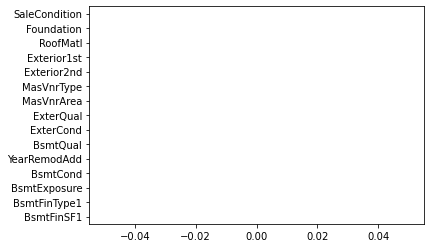

In [18]:
# Bar chart of missing values to verify everything has been filled in
df_house_price_train_objects_missing_data=df_house_price_features.isnull().sum().sort_values(ascending=False).head(15)
sns.barplot(y=df_house_price_train_objects_missing_data.index,x=df_house_price_train_objects_missing_data)
plt.show()

In [19]:
num_train = df_house_price_features.select_dtypes(include=["number"])

In [20]:
## Remove Outliers - Option 2 - From ~2900 to ~1600
#num_train[num_train.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
## Still need to apply to dataframe

In [21]:
# Fix skewed features
house_price_skew = df_house_price_features[num_train.columns].skew().sort_values(ascending=False)
house_price_high_skew = house_price_skew[house_price_skew > 0.5]
pd.DataFrame(house_price_high_skew)

,0
MiscVal,21.950962
PoolArea,17.697766
LotArea,13.116240
LowQualFinSF,12.090757
3SsnPorch,11.377932
KitchenAbvGr,4.302763
BsmtFinSF2,4.146636
EnclosedPorch,4.004404
ScreenPorch,3.947131
BsmtHalfBath,3.932018


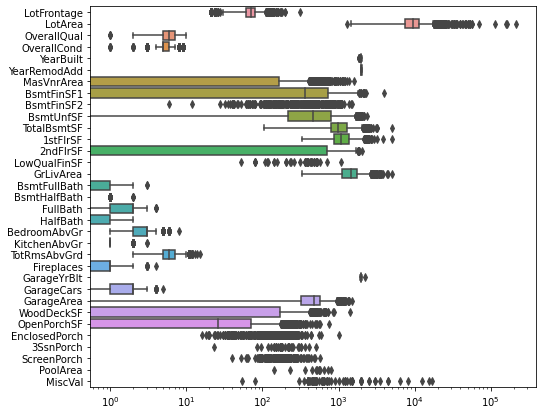

In [22]:
# Create box plots for all numeric features
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
sns.boxplot(data=df_house_price_features[num_train.columns] , orient="h")
plt.show()

In [23]:
## BoxCox Transformation - Option 1
df_house_price_boxcox = [boxcox1p(df_house_price_features[house_price_high_skew.index[i]],boxcox_normmax(df_house_price_features[house_price_high_skew.index[i]]+1)) for i in range(len(house_price_high_skew.index))]

C:\Users\marky\anaconda3\envs\geo_env\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\marky\anaconda3\envs\geo_env\lib\site-packages\scipy\stats\stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [24]:
## BoxCox Transformation - Option 2
#pt = PowerTransformer()
#house_price_high_skew_transformed = pd.DataFrame(pt.fit_transform(df_house_price_features[house_price_high_skew.index]))
#df_house_price_features[house_price_high_skew.index] = house_price_high_skew_transformed

In [25]:
df_house_price_boxcox = pd.DataFrame(df_house_price_boxcox).transpose()

In [26]:
df_house_price_features[house_price_high_skew.index] = df_house_price_boxcox

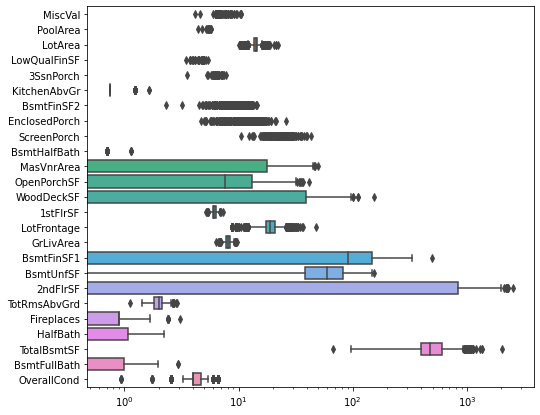

In [27]:
f, ax = plt.subplots(figsize=(8, 7))
ax.set_xscale("log")
sns.boxplot(data=df_house_price_features[house_price_high_skew.index] , orient="h")
plt.show()

In [28]:
# Create Interesting Features
df_house_price_features['BsmtFinType1_Unf'] = 1*(df_house_price_features['BsmtFinType1'] == 'Unf')
df_house_price_features['HasWoodDeck'] = (df_house_price_features['WoodDeckSF'] == 0) * 1
df_house_price_features['HasOpenPorch'] = (df_house_price_features['OpenPorchSF'] == 0) * 1
df_house_price_features['HasEnclosedPorch'] = (df_house_price_features['EnclosedPorch'] == 0) * 1
df_house_price_features['Has3SsnPorch'] = (df_house_price_features['3SsnPorch'] == 0) * 1
df_house_price_features['HasScreenPorch'] = (df_house_price_features['ScreenPorch'] == 0) * 1
df_house_price_features['YearsSinceRemodel'] = df_house_price_features['YrSold'].astype(int) - df_house_price_features['YearRemodAdd'].astype(int)
df_house_price_features['Total_Home_Quality'] = df_house_price_features['OverallQual'] + df_house_price_features['OverallCond']
df_house_price_features = df_house_price_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
df_house_price_features['TotalSF'] = df_house_price_features['TotalBsmtSF'] + df_house_price_features['1stFlrSF'] + df_house_price_features['2ndFlrSF']
df_house_price_features['YrBltAndRemod'] = df_house_price_features['YearBuilt'] + df_house_price_features['YearRemodAdd']

df_house_price_features['Total_sqr_footage'] = (df_house_price_features['BsmtFinSF1'] + df_house_price_features['BsmtFinSF2'] +
                                 df_house_price_features['1stFlrSF'] + df_house_price_features['2ndFlrSF'])
df_house_price_features['Total_Bathrooms'] = (df_house_price_features['FullBath'] + (0.5 * df_house_price_features['HalfBath']) +
                               df_house_price_features['BsmtFullBath'] + (0.5 * df_house_price_features['BsmtHalfBath']))
df_house_price_features['Total_porch_sf'] = (df_house_price_features['OpenPorchSF'] + df_house_price_features['3SsnPorch'] +
                              df_house_price_features['EnclosedPorch'] + df_house_price_features['ScreenPorch'] +
                              df_house_price_features['WoodDeckSF'])
df_house_price_features['TotalBsmtSF'] = df_house_price_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
df_house_price_features['2ndFlrSF'] = df_house_price_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
df_house_price_features['GarageArea'] = df_house_price_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
df_house_price_features['GarageCars'] = df_house_price_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
df_house_price_features['LotFrontage'] = df_house_price_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
df_house_price_features['MasVnrArea'] = df_house_price_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
df_house_price_features['BsmtFinSF1'] = df_house_price_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

df_house_price_features['haspool'] = df_house_price_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df_house_price_features['has2ndfloor'] = df_house_price_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_house_price_features['hasgarage'] = df_house_price_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df_house_price_features['hasbsmt'] = df_house_price_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df_house_price_features['hasfireplace'] = df_house_price_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [29]:
# Feature Transformations
# log transformations to add to dataset
df_house_price_log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
                 'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
                 'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
                 'TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
                 'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YearRemodAdd','TotalSF']

In [30]:
# Logirithmic transformation
df_house_price_log = [list(chain.from_iterable(np.log([1.01 + df_house_price_features[df_house_price_log_features[0]]]))) for i in range(len(df_house_price_log_features))]
df_house_price_log = pd.DataFrame(df_house_price_log).transpose()
df_house_price_log.columns=(df_house_price_log_features)
df_house_price_log = df_house_price_log.add_suffix('_log')
df_house_price_log.head()

,LotFrontage_log,LotArea_log,MasVnrArea_log,BsmtFinSF1_log,BsmtFinSF2_log,BsmtUnfSF_log,TotalBsmtSF_log,1stFlrSF_log,2ndFlrSF_log,LowQualFinSF_log,...,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log
0,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,...,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541
1,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,...,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557
2,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,...,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504
3,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,...,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694
4,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,...,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675


In [31]:
df_house_price_features = pd.concat([df_house_price_features,df_house_price_log],axis=1)
df_house_price_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,GarageArea_log,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,YearRemodAdd_log,TotalSF_log
0,60,RL,18.144573,13.833053,None,Reg,Lvl,Inside,Gtl,CollgCr,...,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541,2.952541
1,20,RL,20.673625,14.117917,None,Reg,Lvl,FR2,Gtl,Veenker,...,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557,3.076557
2,60,RL,18.668046,14.476511,None,IR1,Lvl,Inside,Gtl,CollgCr,...,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504,2.979504
3,70,RL,17.249651,14.106195,None,IR1,Lvl,Corner,Gtl,Crawfor,...,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694,2.904694
4,60,RL,21.314282,15.022007,None,IR1,Lvl,FR2,Gtl,NoRidge,...,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675,3.105675


In [32]:
# Square transformations to add to dataset
df_house_price_squared_features = ['YearRemodAdd', 'LotFrontage_log', 
              'TotalBsmtSF_log', '1stFlrSF_log', '2ndFlrSF_log', 'GrLivArea_log',
              'GarageCars_log', 'GarageArea_log']

In [33]:
# Logirithmic transformation
df_house_price_squared = [list((df_house_price_features[df_house_price_squared_features[i]])**2) for i in range(len(df_house_price_squared_features))]
df_house_price_squared = pd.DataFrame(df_house_price_squared).transpose()
df_house_price_squared.columns=(df_house_price_squared_features)
df_house_price_squared = df_house_price_squared.add_suffix('_sq')
df_house_price_squared.head()

,YearRemodAdd_sq,LotFrontage_log_sq,TotalBsmtSF_log_sq,1stFlrSF_log_sq,2ndFlrSF_log_sq,GrLivArea_log_sq,GarageCars_log_sq,GarageArea_log_sq
0,4012009.0,8.717501,8.717501,8.717501,8.717501,8.717501,8.717501,8.717501
1,3904576.0,9.465205,9.465205,9.465205,9.465205,9.465205,9.465205,9.465205
2,4008004.0,8.877442,8.877442,8.877442,8.877442,8.877442,8.877442,8.877442
3,3880900.0,8.437246,8.437246,8.437246,8.437246,8.437246,8.437246,8.437246
4,4000000.0,9.645217,9.645217,9.645217,9.645217,9.645217,9.645217,9.645217


In [34]:
df_house_price_squared.shape

(2917, 8)

In [35]:
df_house_price_features = pd.concat([df_house_price_features,df_house_price_squared],axis=1)
df_house_price_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,...,YearRemodAdd_log,TotalSF_log,YearRemodAdd_sq,LotFrontage_log_sq,TotalBsmtSF_log_sq,1stFlrSF_log_sq,2ndFlrSF_log_sq,GrLivArea_log_sq,GarageCars_log_sq,GarageArea_log_sq
0,60,RL,18.144573,13.833053,None,Reg,Lvl,Inside,Gtl,CollgCr,...,2.952541,2.952541,4012009.0,8.717501,8.717501,8.717501,8.717501,8.717501,8.717501,8.717501
1,20,RL,20.673625,14.117917,None,Reg,Lvl,FR2,Gtl,Veenker,...,3.076557,3.076557,3904576.0,9.465205,9.465205,9.465205,9.465205,9.465205,9.465205,9.465205
2,60,RL,18.668046,14.476511,None,IR1,Lvl,Inside,Gtl,CollgCr,...,2.979504,2.979504,4008004.0,8.877442,8.877442,8.877442,8.877442,8.877442,8.877442,8.877442
3,70,RL,17.249651,14.106195,None,IR1,Lvl,Corner,Gtl,Crawfor,...,2.904694,2.904694,3880900.0,8.437246,8.437246,8.437246,8.437246,8.437246,8.437246,8.437246
4,60,RL,21.314282,15.022007,None,IR1,Lvl,FR2,Gtl,NoRidge,...,3.105675,3.105675,4000000.0,9.645217,9.645217,9.645217,9.645217,9.645217,9.645217,9.645217


In [36]:
df_house_price_features.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       ...
       'YearRemodAdd_log', 'TotalSF_log', 'YearRemodAdd_sq',
       'LotFrontage_log_sq', 'TotalBsmtSF_log_sq', '1stFlrSF_log_sq',
       '2ndFlrSF_log_sq', 'GrLivArea_log_sq', 'GarageCars_log_sq',
       'GarageArea_log_sq'],
      dtype='object', length=132)

In [37]:
# Encode categorical features - using 'get_dummies'
df_house_price_features = pd.get_dummies(df_house_price_features).reset_index(drop=True)

In [38]:
df_house_price_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.144573,13.833053,7,3.991517,2003,2003,19.433173,144.117855,0.0,29.991056,...,0,0,0,1,0,0,0,0,1,0
1,20.673625,14.117917,6,6.000033,1976,1976,54.598150,181.719175,0.0,44.135417,...,0,0,0,1,0,0,0,0,1,0
2,18.668046,14.476511,7,3.991517,2001,2002,17.768839,110.441028,0.0,56.896538,...,0,0,0,1,0,0,0,0,1,0
3,17.249651,14.106195,7,3.991517,1915,1970,54.598150,61.795312,0.0,64.808860,...,0,0,0,1,1,0,0,0,0,0
4,21.314282,15.022007,8,3.991517,2000,2000,25.404162,136.624594,0.0,61.166382,...,0,0,0,1,0,0,0,0,1,0


In [39]:
# Remove duplicate column names
df_house_price_features = df_house_price_features.loc[:,~df_house_price_features.columns.duplicated()]
df_house_price_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,18.144573,13.833053,7,3.991517,2003,2003,19.433173,144.117855,0.0,29.991056,...,0,0,0,1,0,0,0,0,1,0
1,20.673625,14.117917,6,6.000033,1976,1976,54.598150,181.719175,0.0,44.135417,...,0,0,0,1,0,0,0,0,1,0
2,18.668046,14.476511,7,3.991517,2001,2002,17.768839,110.441028,0.0,56.896538,...,0,0,0,1,0,0,0,0,1,0
3,17.249651,14.106195,7,3.991517,1915,1970,54.598150,61.795312,0.0,64.808860,...,0,0,0,1,1,0,0,0,0,0
4,21.314282,15.022007,8,3.991517,2000,2000,25.404162,136.624594,0.0,61.166382,...,0,0,0,1,0,0,0,0,1,0


### Model

In [40]:
# Recreate training and test sets
X = df_house_price_features.iloc[:len(df_house_price_sale_price), :]
X_test = df_house_price_features.iloc[len(df_house_price_sale_price):, :]
X.shape, df_house_price_sale_price.shape, X_test.shape

((1458, 378), (1458,), (1459, 378))

In [41]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

In [46]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, df_house_price_sale_price, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [47]:
# Set up models
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [48]:
# Train models

In [49]:
scores = {}
score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

lightgbm: 0.1155 (0.0165)


In [50]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

[18:07:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[18:11:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[18:12:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[18:14:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:16

In [51]:
score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

SVR: 0.1097 (0.0196)


In [52]:
score = cv_rmse(ridge)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())

ridge: 0.1097 (0.0161)


In [53]:
score = cv_rmse(rf)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

rf: 0.1366 (0.0188)


In [54]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

gbr: 0.1126 (0.0165)


In [ ]:
# Fit the models

In [55]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(df_house_price_sale_price))

stack_gen
[19:26:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[19:28:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[19:30:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[19:32:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[19:35:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
[19:51:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression

In [57]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, df_house_price_sale_price)

lightgbm


In [58]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, df_house_price_sale_price)

xgboost
[20:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


In [59]:
print('Svr')
svr_model_full_data = svr.fit(X, df_house_price_sale_price)

Svr


In [60]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, df_house_price_sale_price)

Ridge


In [61]:
print('RandomForest')
rf_model_full_data = rf.fit(X, df_house_price_sale_price)

RandomForest


In [62]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, df_house_price_sale_price)

GradientBoosting


### Analysis

In [63]:
# Blend Models and Identify Best Performers
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    return ((0.1 * ridge_model_full_data.predict(X)) + \
            (0.2 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.1 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.05 * rf_model_full_data.predict(X)) + \
            (0.35 * stack_gen_model.predict(np.array(X))))

In [64]:
# Get final precitions from the blended model
blended_score = rmsle(df_house_price_sale_price, blended_predictions(X))
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
0.07516093911955612


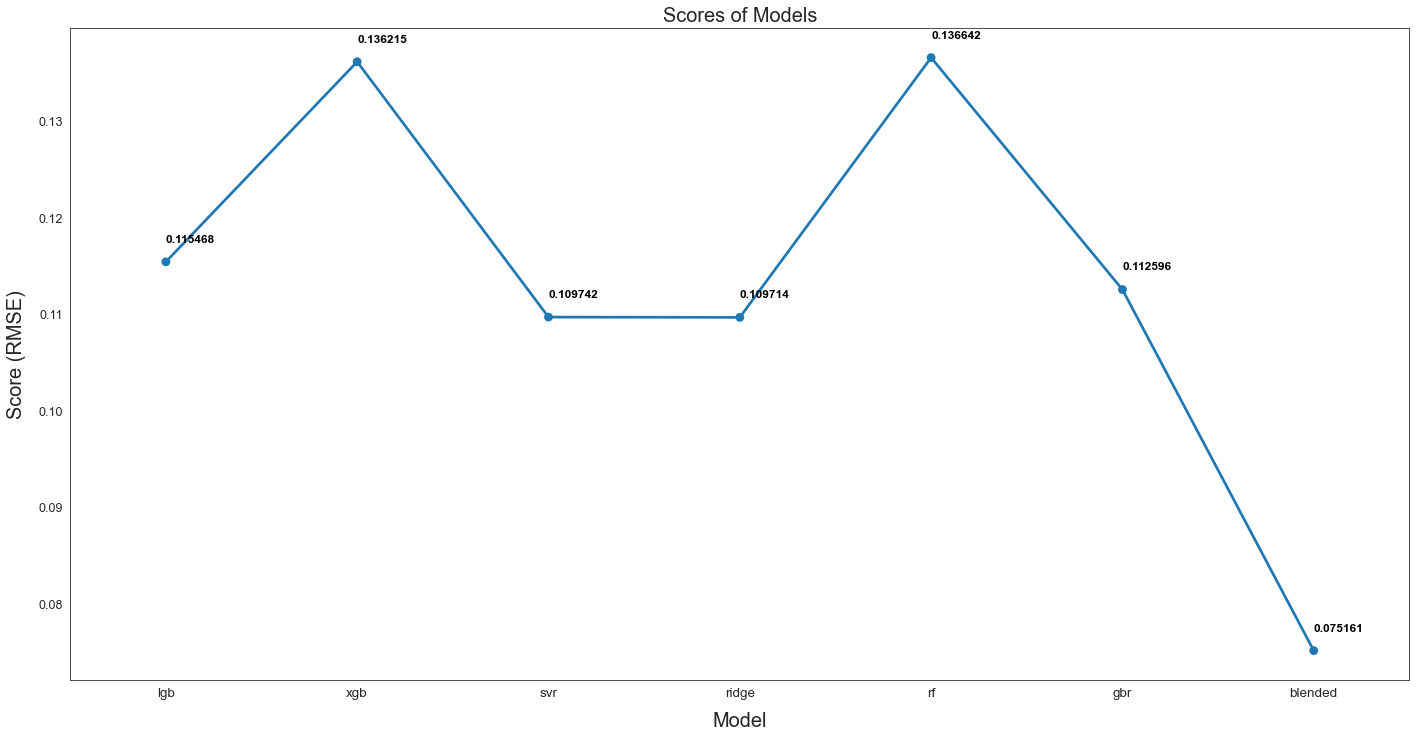

In [65]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [ ]:
# Submit Predictions

In [ ]:
## Read in sample_submission dataframe
#submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
#submission.shape

In [ ]:
## Fix outleir predictions
#q1 = submission['SalePrice'].quantile(0.0045)
#q2 = submission['SalePrice'].quantile(0.99)
#submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x*0.77)
#submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x*1.1)
#submission.to_csv("submission_regression1.csv", index=False)

In [ ]:
# Scale predictions
#submission['SalePrice'] *= 1.001619
#submission.to_csv("submission_regression2.csv", index=False)